<h1 style='color: blue; font-size: 50px; font-weight: bold;'> Case Data Master 2024 - Leonardo Aderaldo Vargas
</h1>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
</p>  

O Case proposto apresenta o histórico de dois anos (2015-2017) de uma empresa que oferece serviço de streaming de música baseado em assinatura.

Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente. Os usuários podem cancelar ativamente sua associação a qualquer momento. 

Para este cenário, temos os seguintes desafios:

1) Problema de Classificação:

- Sabendo que existe a seguinte ação de retenção para clientes: Quando detectamos que um cliente não renova a assinatura, oferecemos 3 meses grátis. Porém, identificamos que essa ação é muito reativa e entendemos que uma abordagem proativa seria mais efetiva.
- Sendo assim, é proposto que você crie um modelo classificador para prever clientes que serão um churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no período analisado e 3 meses depois desse período ele não é mais ativo, ou porque cancelou ou não renovou a assinatura) e indique os clientes que serão direcionados para ação de forma proativa
- Assumindo que, usando a ação de forma proativa, 50% dos clientes que iriam cancelar (Verdadeiro Positivo) respondem de forma positiva e continuam ativos por mais um ano, qual sua avaliação sobre sua solução?
- Mínimo esperado: Criação de Target, Feature Engineering, Feature Selection, Predictive Modeling, Quantidade de clientes retidos e resultado financeiro da ação.


2) Problema de Clusterização

- Considerando o problema escolhido (Churn), realize uma análise não-supervisionada dos clientes com objetivo de aprofundar a compreensão sobre características deles.

- Algumas sugestões: análise de clientes com diferentes perfis de uso da plataforma, com as variadas estimações de churn, análise de perfis com diferentes volatidade/incerteza nas respostas de churn, análise de erros sistemáticos cometidos pelos modelos do case supervisionado, análise da variação temporal no comportamento dos clientes da base.


<h1 style='color: Orange; font-size: 50px; font-weight: bold;'> Pontos de Desenvolvimento do Case
</h1>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
</p>  

### 1) Criação de Target

- Criar a regra da Target

### 2) Separação de Amostras

- Separação de um conjunto de dados de Treino, Validação, Teste e OOT
- Em cada amostra, conferir se elas são similares. Nessa etapa, posso ver tanto a distribuição de Target quanto compará-las através de Testes de Hipótese como chi2 ou KS

### 3) Análise Exploratória

- Identificar quantas variáveis contínuas e categóricas temos em percentual através de um gráfico de barras
- Identificar qual a porcentagem de valores ausentes em cada variável através de um gráfico de barras
- Para variáveis contínuas: analisar correlação entre as variáveis, analisar distribuição via boxplot a fim de entender se há diferença significativa nas distribuiçoes de cada feature para a Target 0 ou 1, presença de outliers via IIQ...
- Para variáveis categóricas: analisar as distribuições de cada categoria, analisar o Weight of Evidence a fim de entender a relação com a target ou usar testes de chi2...

### 4) Feature Engineering

> 1. Desenvolver features factíveis, úteis e criativas para o meu problema

### 5) Pré-Processamento

> 1. Aplicar Target Encoder através do WOE para as categóricas

> 2. Entender qual método de imputação usarei e se usarei algo...

> 3. Para variáveis contínuas, manter apenas instâncias entre o p1 e o p99 para eliminar erros

> 4. Fazer um cálculo de PSI para as variáveis contínuas e categóricas a fim de garantir features estáveis e, consequentemente, predições estáveis

> 5. Aplicar Escolanemento

### 6) Feature Selection

> 1. Para variáveis contínuas: aplicar o Variance Threshold e eliminar variáveis altamente correlacionadas

> 2. Para variáveis categóricas: aplicar o WOE e calcular um IV, mantendo apenas as categóricas com IV alto

> 3. Rodar uma Random Forest Feature Importance para fazer o filtro final

### 7) Classificador

> 1.  Treinar uma Regressão Logística, Random Forest e um XGBoost
> 2. Fazer otimização de hiperparâmetros
> 3. Fazer calibração de probabilidades
> 4. Definir o threshold de decisão para classes 0 ou 1

### 8) Análise de Resultados

> 1. Responder as questões propostas

### 9) Clusterização

> 1. Fazer um não supervisionado que seja capaz de inferir algo próximo ao classificador e discutir as mudanças
> 2. Testarei um KMeans, Hierarquico ou DBSCAN a depender da natureza dos meus dados


<font color='purple' style='font-size: 40px;'> Bibliotecas </font>
<hr style='border: 2px solid purple;'>

In [15]:

## Módulo de Funções
from functions_analise_exploratoria import *
from functions_feature_engineering import *
from functions_machine_learning import *
from functions_pre_processamento import *

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

<font color='yellow' style='font-size: 40px;'> Importação de Dados </font>
<hr style='border: 2px solid yellow;'>

### 1) Base Members

> 1. msno: user id

> 2. city: cidade

> 3. bd: idade --> essa coluna tem outliers desde -7000 até 2015

> 4. registered_via: tipo de registro

> 5. registration_init_time: data do registro inicial no formato %Y%m%d

> 6. gender: gênero

> 7. is_ativo: assinatura ativa (Target Classificador Problema 1)

> 8. safra: safra

### 2) Base Transacations

> 1. msno: user id

> 2. payment_method_id: método de pagamento

> 3. payment_plan_days: quantidade de dias de afiliação

> 4. plan_list_price: preço

> 5. actual_amount_paid: montante pago

> 6. is_auto_renew: flag renovação automática

> 7. transaction_date: data da transação no formato %Y%m%d

> 8. membership_expire_date: data de expiração da afiliação

> 9. is_cancel: flag que indica se o usuário cancelou ou não a afiliação nesta transação

### 3) Base User Logs

> 1. msno: user id

> 2. safra

> 3. num_25: quantidade de músicas tocadas por menos de 25% da duração da música

> 4. num_50: quantidade de músicas tocadas entre 25% e 50% da duração da música

> 5. num_75: quantidade de músicas tocadas entre 50% e 75% da duração da música

> 6. num_985: quantidade de músicas tocadas entre 75% até 98.5% da duração da música

> 7. num_100: quantidade de músicas tocadas entre 98.5% até 100% da duração da música

> 8. num_unq: quantidade única de músicas já tocadas

> 9. total_scs: número total de segundos tocados

<font color='red' style='font-size: 40px;'> 1) Definição da Target</font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Detecção dos Clientes que podem ter TARGET </font>
<hr style='border: 2px solid green;'>

> 1. Como a base possui muitos clientes, decidiu-se avaliar quais já contraram a assinatura em um mês pelo menos.

> 2. Clientes que nunca contraram nunca foram ativos, logo, não deveriam entrar no nosso modelo de Churn


In [2]:
tabela_de_membros = pd.read_parquet('../00_DataMaster/data/members.parquet')[["msno", "safra", "is_ativo"]]
membros_que_tem_pelo_menos_uma_marcacao_de_ativo = tabela_de_membros.groupby("msno", as_index = False)["is_ativo"].sum().rename({"is_ativo":"quantidade_de_meses_de_atividade"}, axis = 1)
membros_que_tem_pelo_menos_uma_marcacao_de_ativo = membros_que_tem_pelo_menos_uma_marcacao_de_ativo.loc[membros_que_tem_pelo_menos_uma_marcacao_de_ativo["quantidade_de_meses_de_atividade"] > 0]

quantidade_de_meses_de_atividade = int(membros_que_tem_pelo_menos_uma_marcacao_de_ativo["msno"].nunique())

print(f"A quantidade de clientes com pelo menos um mês de assinatura é {quantidade_de_meses_de_atividade}")

A quantidade de clientes com pelo menos um mês de assinatura é 1563999


# <font color='green' style='font-size: 30px;'> 1.2) Amostragem Aleatória de 30% do Público para desenvolvimento do Case - Apenas clientes que foram ativos em pelo menos 1 mês </font>
<hr style='border: 2px solid green;'>

> 1. Como o case apresenta em torno de 1.5MM de clientes que já contraram uma assinatura, decidiu-se aplicar uma amostragem aleatória de 30% do público para o desenvolvimento

> 2. A justificativa de criar uma amostra se dá pelo fato da base verdadeira ser muito grande, impossibilitando de ser trabalhada em sua totalidade por limitações de hardware

> 3. Pela Lei dos Grandes Números, sabe-se que à medida que o tamanho da amostra aumenta, a valor esperado das observações da amostra se aproxima do valor esperado da população.

> 4. Sendo assim, pelo tamanho suficiente da amostra, sabe-se que ela assemelha-se muito a população, garantindo que todo o case possa ser analisado através de uma amostra.


In [3]:
amostra_aleatoria = membros_que_tem_pelo_menos_uma_marcacao_de_ativo[["msno"]].drop_duplicates().sample(frac = 0.3, random_state = 42, replace = False)
amostra_aleatoria.to_parquet("../00_DataMaster/data/amostra_aleatoria.parquet", index = False)

# <font color='green' style='font-size: 30px;'> 1.3) Criação da Target </font>
<hr style='border: 2px solid green;'>

> 1. Para a criação da Target, avaliou-se se o cliente era ativo em M e deixou de ser ou em M+1, M+2 ou M+3

> 2. Além disso, decidiu-se retirar do desenvolvimento do case as amostras da safra 2016-12-01, pois elas não possuem Target e, portanto, não podemos avaliar nenhum tipo de performance em cima desses casos

### Considerações

-  '201601', --> OOT
-  '201602', --> OOT
-  '201603', --> TRAINING/TESTE
-  '201604', --> TRAINING/TESTE
-  '201605', --> TRAINING/TESTE
-  '201606', --> TRAINING/TESTE
-  '201607', --> TRAINING/TESTE
-  '201608', --> TRAINING/TESTE
-  '201609', --> TRAINING/TESTE
-  '201610', --> TRAINING/TESTE
-  '201611', --> TRAINING/TESTE
-  '201612' --> Não tem Target

In [4]:
### Amostra de Desenvolvimento + Base de Membros
amostra_aleatoria = pd.read_parquet("../00_DataMaster/data/amostra_aleatoria.parquet")
tabela_de_membros = pd.read_parquet('../00_DataMaster/data/members.parquet')[["msno", "safra", "is_ativo"]]

### Puxando Informações de safra e atividade para a amostra
amostra_aleatoria_com_target = amostra_aleatoria.merge(tabela_de_membros, on = ["msno"], how = "left").sort_values(by = ["msno", "safra"], ascending = True)
amostra_aleatoria_com_target['safra'] = pd.to_datetime(amostra_aleatoria_com_target['safra'], format='%Y%m')

# Criar as colunas de verificação para os próximos 3 meses
amostra_aleatoria_com_target['ativo_M+1'] = amostra_aleatoria_com_target.groupby('msno')['is_ativo'].shift(-1)
amostra_aleatoria_com_target['ativo_M+2'] = amostra_aleatoria_com_target.groupby('msno')['is_ativo'].shift(-2)
amostra_aleatoria_com_target['ativo_M+3'] = amostra_aleatoria_com_target.groupby('msno')['is_ativo'].shift(-3)

# MARCAÇÃO DE CHURN E NÃO CHURN
amostra_aleatoria_com_target["churn"] = np.where(
    (amostra_aleatoria_com_target['is_ativo'] == 1) & (amostra_aleatoria_com_target['ativo_M+1'] == 0) | 
    (amostra_aleatoria_com_target['is_ativo'] == 1) & (amostra_aleatoria_com_target['ativo_M+2'] == 0) |
    (amostra_aleatoria_com_target['is_ativo'] == 1) & (amostra_aleatoria_com_target['ativo_M+3'] == 0),
    1,  ### MARCAÇÃO DE CHURN
    0   ### MARCAÇÃO DE NÃO CHURN
)

amostra_aleatoria_com_target.tail(12)

,msno,safra,is_ativo,ativo_M+1,ativo_M+2,ativo_M+3,churn
2807397,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-01-01,1,1.00,0.00,0.00,1
2807407,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-02-01,1,0.00,0.00,0.00,1
2807402,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-03-01,0,0.00,0.00,0.00,0
2807406,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-04-01,0,0.00,0.00,1.00,0
2807401,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-05-01,0,0.00,1.00,1.00,0
2807403,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-06-01,0,1.00,1.00,1.00,0
2807398,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-07-01,1,1.00,1.00,1.00,0
2807396,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-08-01,1,1.00,1.00,1.00,0
2807404,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-09-01,1,1.00,1.00,1.00,0
2807400,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-10-01,1,1.00,1.00,NaN,0


A quantidade de amostras com Churn é 484523
A quantidade de amostras distintos sem Churn é 4121817


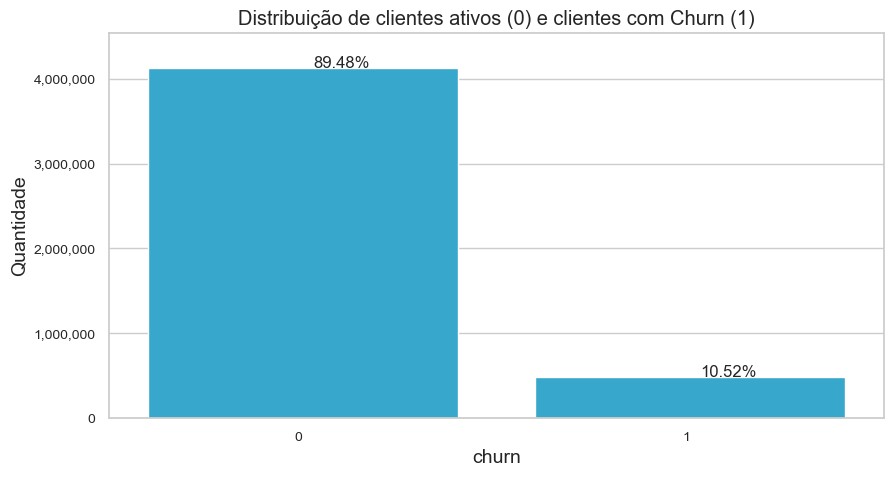

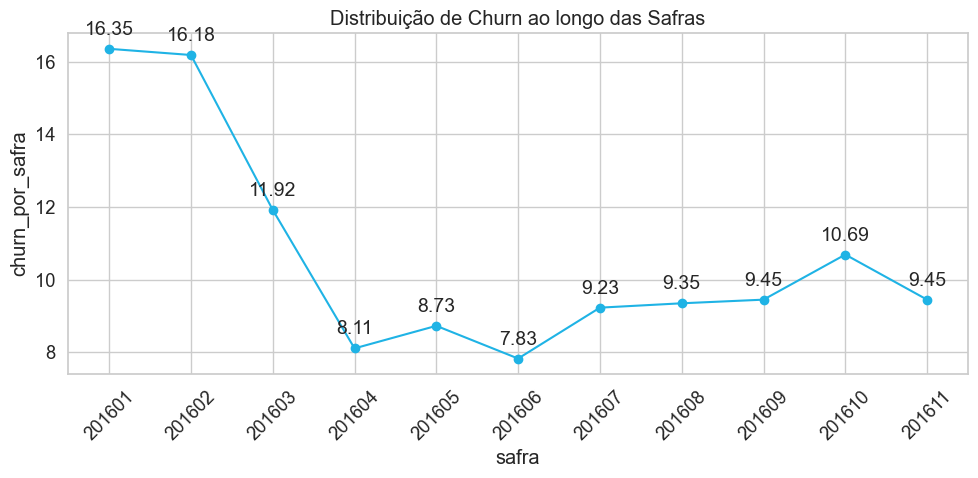

In [5]:
# RETIRANDO A SAFRA DE 2016-12-01 POIS ELA NÃO POSSUI TARGET

amostra_aleatoria_com_target = amostra_aleatoria_com_target.loc[amostra_aleatoria_com_target["safra"] != "2016-12-01"]
amostra_aleatoria_com_target["safra"] = amostra_aleatoria_com_target["safra"].apply(lambda x: x.strftime('%Y%m'))

# VOLUMETRIA
quantidade_de_amostras_com_churn = amostra_aleatoria_com_target.loc[amostra_aleatoria_com_target["churn"] == 1].shape[0]
quantidade_de_amostras_sem_churn = amostra_aleatoria_com_target.loc[amostra_aleatoria_com_target["churn"] == 0].shape[0]

print(f"A quantidade de amostras com Churn é {quantidade_de_amostras_com_churn}")
print(f"A quantidade de amostras distintos sem Churn é {quantidade_de_amostras_sem_churn}")

plota_barras(['churn'], False, amostra_aleatoria_com_target, 1, 1, 'Distribuição de clientes ativos (0) e clientes com Churn (1)', 0)

# VOLUMETRIA AO LONGO DAS SAFRAS
churn_por_safra = amostra_aleatoria_com_target[["msno", "safra", "churn"]].groupby("safra").agg({"churn":"sum", "msno":"count"}).reset_index()
churn_por_safra["churn_por_safra"] = round(churn_por_safra["churn"]/churn_por_safra["msno"]*100, 2)
plota_grafico_linhas_temporal(churn_por_safra, "safra", "churn_por_safra", "Distribuição de Churn ao longo das Safras")

In [6]:
amostra_aleatoria_com_target[["msno", "safra", "churn"]].to_parquet("../00_DataMaster/data/amostra_aleatoria_com_target.parquet", index = False)

<font color='red' style='font-size: 40px;'> 2) Seleção das Amostras de Treinamento, Validação, Teste e OOT </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Puxando informações para a amostra aleatória </font>
<hr style='border: 2px solid green;'>

> 1. Como selecionamos uma amostra aleatória, devemos puxar as demais variáveis para iniciarmos efetivamente o case

> 2. Embora hajam safras mais antigas para as tabelas de Transações e User Logs, para as análises iniciais, optou-se por garantir manter as variáveis no mesmo intervalo temporal da Target (201601~201611)


In [7]:
# Amostra Aleatória
amostra_aleatoria_com_target = pd.read_parquet("../00_DataMaster/data/amostra_aleatoria_com_target.parquet")
amostra_aleatoria_com_target["safra"] = amostra_aleatoria_com_target["safra"].apply(lambda x:str(x))

# Tabela de Membros
tabela_de_membros = pd.read_parquet("../00_DataMaster/data/members.parquet").drop("is_ativo", axis = 1)
tabela_de_membros["safra"] = tabela_de_membros["safra"].apply(lambda x:str(x))

# Tabela de Transações
tabela_de_transacoes = pd.read_parquet("../00_DataMaster/data/transactions.parquet")
tabela_de_transacoes["safra"] = tabela_de_transacoes["safra"].apply(lambda x:str(x))
tabela_de_transacoes = tabela_de_transacoes.loc[tabela_de_transacoes["safra"].isin(['201601', '201602', '201603', '201604', '201605', '201606','201607', '201608', '201609', '201610', '201611'])]

# Tabela de User Logs
tabela_user_logs = pd.read_parquet("../00_DataMaster/data/user_logs.parquet")
tabela_user_logs["safra"] = tabela_user_logs["safra"].apply(lambda x:str(x))
tabela_user_logs = tabela_user_logs.loc[tabela_user_logs["safra"].isin(['201601', '201602', '201603', '201604', '201605', '201606','201607', '201608', '201609', '201610', '201611'])]


In [8]:
df_case_data_masters = amostra_aleatoria_com_target.merge(tabela_de_membros, on = ["msno", "safra"], how = "left")
df_case_data_masters = df_case_data_masters.merge(tabela_de_transacoes, on = ["msno", "safra"], how = "left")
df_case_data_masters = df_case_data_masters.merge(tabela_user_logs, on = ["msno", "safra"], how = "left")

In [9]:
df_case_data_masters.to_parquet("../00_DataMaster/data/df_case_data_masters.parquet", index = False)

# <font color='green' style='font-size: 30px;'> 2.2) Separação em Treino, Validação, Teste e OOT </font>
<hr style='border: 2px solid green;'>

> 1. A fim de evitar Data Leakage, decidiu-se separar os dados em treino, validação, teste e oot

> 2. Para cenário, separou-se da seguinte maneira:

- Treino + Validação --> 80% dos IDs entre 201603 e 201611, sendo 90% para Treinamento do Modelo e 10% para Validação 
- Teste --> 20% dos IDs do treino
- OOT --> Todos os IDs para 201601 e 201602, pois como esses meses tem maior quantidade de CHURN, seria interessante ver se o modelo possui boa performance em cenários atípicos


In [74]:
amostra_treino_validacao = (
    df_case_data_masters
        .loc[~df_case_data_masters["safra"].isin(["201601", "201602"])]
        [["msno"]]
        .drop_duplicates()
        .sample(frac = 0.8, random_state = 42, replace = False)
)

train = (
    amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)
    [["msno"]]
    .drop_duplicates()
) 

valid = (
    amostra_treino_validacao.loc[~amostra_treino_validacao["msno"].isin(list(train["msno"].unique()))]
    [["msno"]]
    .drop_duplicates()
)

test = (
    df_case_data_masters
        .loc[
            (~df_case_data_masters["safra"].isin(["201601", "201602"])) & 
            (~df_case_data_masters["msno"].isin(list(train["msno"].unique()))) & 
            (~df_case_data_masters["msno"].isin(list(valid["msno"].unique())))
        ]
        [["msno"]]
        .drop_duplicates()
        .sample(frac = 0.8, random_state = 42, replace = False)
)

oot = (
    df_case_data_masters
        .loc[df_case_data_masters["safra"].isin(["201601", "201602"])]
        [["msno"]]
        .drop_duplicates()
)


print(f"A quantidade de IDs distintos no Treino (201603~201611) é: {train.shape[0]}")
print(f"A quantidade de IDs distintos na Validação (201603~201611) é: {valid.shape[0]}")
print(f"A quantidade de IDs distintos no Teste (201603~201611) é: {test.shape[0]}")
print(f"A quantidade de IDs distintos no OOT (201601~201602) é: {oot.shape[0]}")
print()
print(f"A quantidade de amostras no Treino (201603~201611) é: {df_train.shape[0]}")
print(f"A quantidade de amostras na Validação (201603~201611) é: {df_valid.shape[0]}")
print(f"A quantidade de amostras no Teste (201603~201611) é: {df_test.shape[0]}")
print(f"A quantidade de amostras no OOT (201601~201602) é: {df_oot.shape[0]}")



A quantidade de IDs distintos no Treino (201603~201611) é: 333679
A quantidade de IDs distintos na Validação (201603~201611) é: 37075
A quantidade de IDs distintos no Teste (201603~201611) é: 74150
A quantidade de IDs distintos no OOT (201601~201602) é: 376818

A quantidade de amostras no Treino (201603~201611) é: 2783274
A quantidade de amostras na Validação (201603~201611) é: 309571
A quantidade de amostras no Teste (201603~201611) é: 619019
A quantidade de amostras no OOT (201601~201602) é: 739708


In [60]:
df_train = train.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602"])], on = "msno", how = "left")
df_valid = valid.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602"])], on = "msno", how = "left")
df_test = test.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602"])], on = "msno", how = "left")
df_oot = oot.merge(df_case_data_masters.loc[df_case_data_masters["safra"].isin(["201601", "201602"])], on = "msno", how = "left")

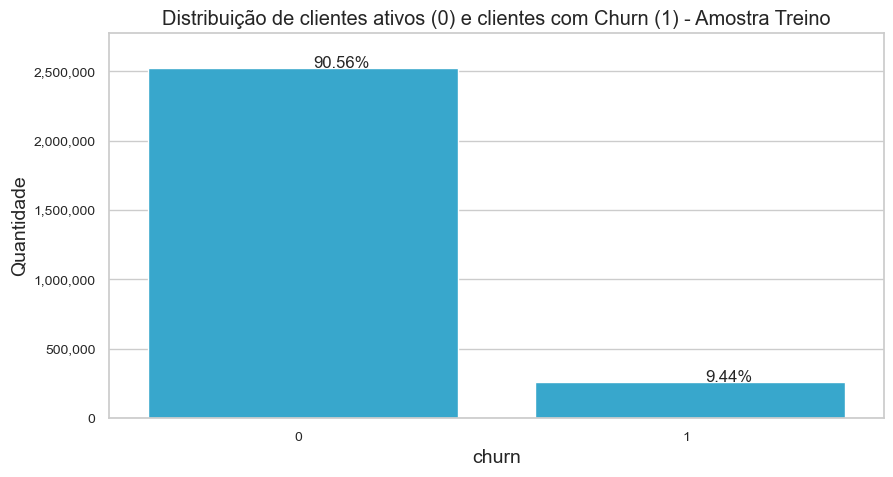

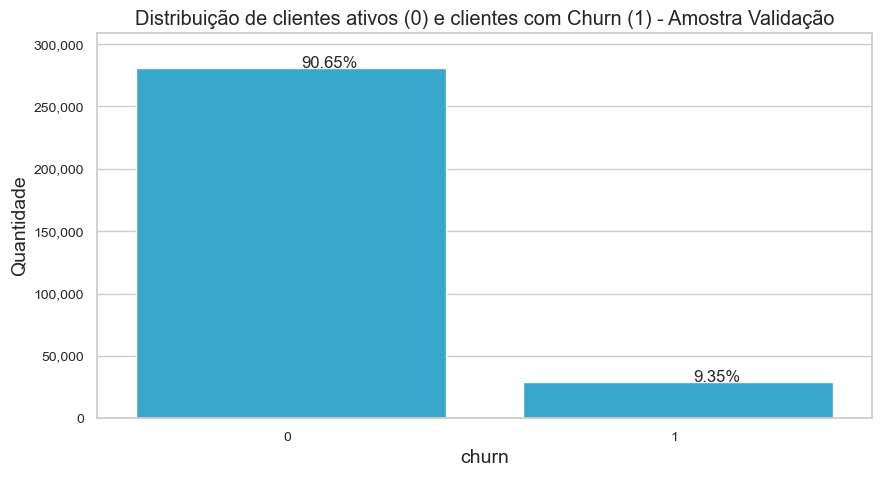

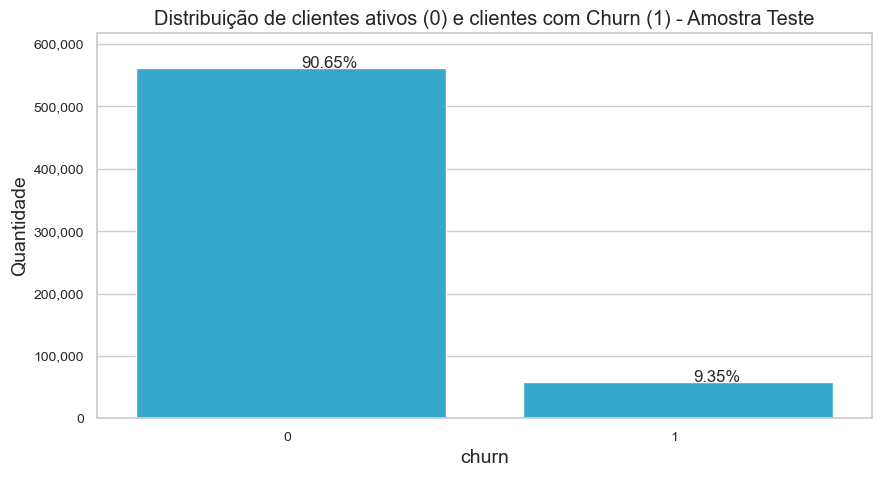

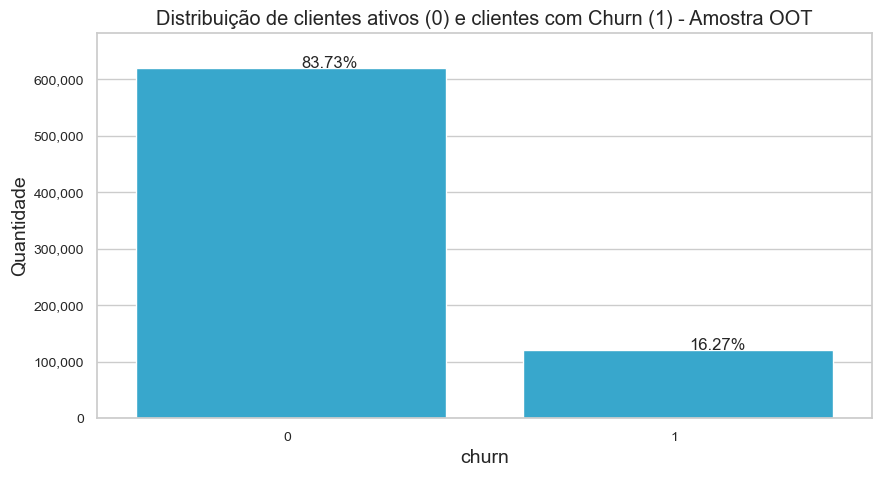

In [70]:
amostras = [df_train, df_valid, df_test, df_oot]
tipo = ["Treino", "Validação", "Teste", "OOT"]
i = 0
for amostra in amostras:

    plota_barras(['churn'], False, amostra, 1, 1, f'Distribuição de clientes ativos (0) e clientes com Churn (1) - Amostra {tipo[i]}', 0)

    i = i + 1

In [72]:
df_train.to_parquet("../00_DataMaster/data/df_train.parquet", index = False)
df_valid.to_parquet("../00_DataMaster/data/df_valid.parquet", index = False)
df_test.to_parquet("../00_DataMaster/data/df_test.parquet", index = False)
df_oot.to_parquet("../00_DataMaster/data/df_oot.parquet", index = False)

<font color='red' style='font-size: 40px;'> 3)  Análise Exploratória - Feita apenas com a Amostra de **TREINO** ou **OOT**</font>
<hr style='border: 2px solid red;'>

In [113]:
df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")
df_valid = pd.read_parquet("../00_DataMaster/data/df_valid.parquet")
df_test = pd.read_parquet("../00_DataMaster/data/df_test.parquet")
df_oot = pd.read_parquet("../00_DataMaster/data/df_oot.parquet")

# <font color='green' style='font-size: 30px;'> 3.1) Identificação de tipos de variáveis </font>
<hr style='border: 2px solid green;'>

> 1. Inicialmente, decidiu-se analisar quantos valores distintos há em cada variável

> 2. Variáveis com menos valores distintos tendem a ser categóricas, ao passo que muitos valores distintos tendem a ser contínuas

> 3. Além disso, somado a descrição da variável, pode-se inferir seu tipo com mais acurácia

> 4. Sendo assim, definiu-se que:

- variaveis_categoricas = ['is_auto_renew', 'is_cancel', 'gender', 'registered_via', 'city', 'payment_method_id']

- variaveis_continuas = ['payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_75', 'num_50', 'num_985','num_25', 'num_unq', 'num_100', 'total_secs']

- variaveis_de_data = ["safra", "registration_init_time", "transaction_date", "membership_expire_date"]

- target = ["churn"]

- user_id = ["msno"]

In [123]:
# Dados das variáveis e suas descrições
data = {
    'base': [
        'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members',
        'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions',
        'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs'
    ],
    'variavel': [
        'msno', 'city', 'bd', 'registered_via', 'registration_init_time', 'gender', 'is_ativo', 'safra',
        'msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'transaction_date', 'membership_expire_date', 'is_cancel',
        'msno', 'safra', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'
    ],
    'descricao': [
        'user id', 'cidade', 'essa coluna tem outliers desde -7000 até 2015', 'tipo de registro', 'data do registro inicial no formato %Y%m%d', 'gênero', 'assinatura ativa (Target Classificador Problema 1)', 'safra',
        'user id', 'método de pagamento', 'quantidade de dias de afiliação', 'preço', 'montante pago', 'flag renovação automática', 'data da transação no formato %Y%m%d', 'data de expiração da afiliação', 'flag que indica se o usuário cancelou ou não a afiliação nesta transação',
        'user id', 'safra', 'quantidade de músicas tocadas por menos de 25% da duração da música', 'quantidade de músicas tocadas entre 25% e 50% da duração da música', 'quantidade de músicas tocadas entre 50% e 75% da duração da música', 'quantidade de músicas tocadas entre 75% até 98.5% da duração da música', 'quantidade de músicas tocadas entre 98.5% até 100% da duração da música', 'quantidade única de músicas já tocadas', 'numero total de segundos tocados'
    ]
}

df_variaveis_descricoes = pd.DataFrame(data)

# Dados dos tipos das variáveis
target = ["churn"]
user_id = ["msno"]
variaveis_de_data = ["safra", "registration_init_time", "transaction_date", "membership_expire_date"]
variaveis_categoricas_continuas = {}

for var in df_train.drop(target + user_id + variaveis_de_data, axis=1).columns:
    variaveis_categoricas_continuas[var] = int(df_train[var].nunique())

variaveis_categoricas_continuas_df = pd.DataFrame(list(variaveis_categoricas_continuas.items()), columns=['variavel', 'numero_valores_unicos']).sort_values(by = "numero_valores_unicos", ascending = True)
variaveis_categoricas_continuas_df = variaveis_categoricas_continuas_df.merge(df_variaveis_descricoes, on = "variavel", how = "left")

display(variaveis_categoricas_continuas_df)


,variavel,numero_valores_unicos,base,descricao
0,is_auto_renew,2,Base Transactions,flag renovação automática
1,is_cancel,2,Base Transactions,flag que indica se o usuário cancelou ou não a afiliação nesta transação
2,gender,2,Base Members,gênero
3,registered_via,7,Base Members,tipo de registro
4,city,21,Base Members,cidade
5,payment_plan_days,27,Base Transactions,quantidade de dias de afiliação
6,payment_method_id,34,Base Transactions,método de pagamento
7,plan_list_price,39,Base Transactions,preço
8,actual_amount_paid,39,Base Transactions,montante pago
9,bd,171,Base Members,essa coluna tem outliers desde -7000 até 2015


In [124]:
variaveis_categoricas = ['is_auto_renew', 'is_cancel', 'gender', 'registered_via', 'city', 'payment_method_id']
variaveis_continuas = ['payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_75', 'num_50', 'num_985','num_25', 'num_unq', 'num_100', 'total_secs']
variaveis_de_data = ["safra", "registration_init_time", "transaction_date", "membership_expire_date"]
target = ["churn"]
user_id = ["msno"]

# <font color='green' style='font-size: 30px;'> 3.2) Identificação inconsistências nas variáveis </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 3.3) Análise de Variáveis Contínuas </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 3.4) Análise de Variáveis Categóricas </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 3.5) Análise Temporal </font>
<hr style='border: 2px solid green;'>

<font color='red' style='font-size: 40px;'> 4)  Feature Engineering </font>
<hr style='border: 2px solid red;'>

<font color='red' style='font-size: 40px;'> 5)  Pré-Processamento </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 5.1) Tratamento de Valores Ausentes </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 5.2) Encoder de Categóricas </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 5.3) Escalonamento de Variáveis </font>
<hr style='border: 2px solid green;'>

<font color='red' style='font-size: 40px;'> 6)  Feature Selection </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 6.1) Variance Threshold </font>
<hr style='border: 2px solid green;'>


# <font color='green' style='font-size: 30px;'> 6.2) Information Value </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 6.3) Random Forest Feature Importance </font>
<hr style='border: 2px solid green;'>

<font color='red' style='font-size: 40px;'> 7)  Modelagem (Foco em Aprendizado Supervisionado) </font>
<hr style='border: 2px solid red;'>

<font color='red' style='font-size: 40px;'> 8) Otimização </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 8.1) Bayes Search </font>
<hr style='border: 2px solid green;'>

<font color='red' style='font-size: 40px;'> 9) Resultados Esperados - Problema 1 </font>
<hr style='border: 2px solid red;'>

<font color='red' style='font-size: 40px;'> 10) Modelagem (Foco em Aprendizado Não-Supervisionado) </font>
<hr style='border: 2px solid red;'>

<font color='red' style='font-size: 40px;'> 11) Resultados Esperados - Problema 2 </font>
<hr style='border: 2px solid red;'>